In [1]:
from random import random
from numpy.random import normal
from random import shuffle
from sim import *

In [2]:
CARRYING_CAPACITY = 2 ** 13
START_N_GENOMES = 2 ** 9
N_GENES = 2 ** 9
PLOIDY = 2
MUTATION_RATE = 2 ** 2 / N_GENES
CROSSING_OVER = True
CROSSINGOVER_LENGTH_MEAN = 2 ** 7
CROSSINGOVER_LENGTH_SD = 2 ** 2
START_FRAC_SEX_GENOMES = 0.05 # 0.1
N_GENERATIONS = 2 ** 7

In [9]:
CARRYING_CAPACITY = 2000
START_N_GENOMES = 100
N_GENES = 100
PLOIDY = 2
MUTATION_RATE = 5 / N_GENES
CROSSING_OVER = True
CROSSINGOVER_LENGTH_MEAN = 10
CROSSINGOVER_LENGTH_SD = 1
START_FRAC_SEX_GENOMES = 0.1
N_GENERATIONS = 20

# Run simulation

---

In [10]:
sim = Simulation(
    c=CARRYING_CAPACITY,
    n=N_GENES,
    p=PLOIDY,
    s=START_N_GENOMES,
    h_mean=CROSSINGOVER_LENGTH_MEAN,
    h_sd=CROSSINGOVER_LENGTH_SD,
    x=START_FRAC_SEX_GENOMES,
    g=N_GENERATIONS,
    m=MUTATION_RATE
)
sim.start()

In [11]:
sim.history['n_sex_allele']

[14,
 28,
 36,
 28,
 32,
 60,
 120,
 232,
 288,
 576,
 652,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000]

In [13]:
sim.history['n_individuals']

[100,
 372,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000]

---

## Plot

In [30]:
import matplotlib.pyplot as plt

In [31]:
n_sex_allele = sim.history['n_sex_allele']
n_individuals = sim.history['n_individuals']

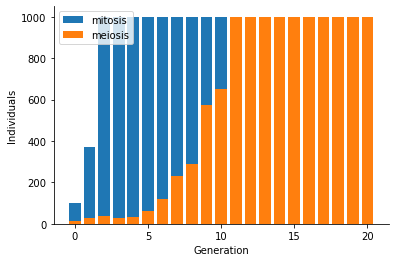

In [32]:
plt.bar([i for i in range(len(n_individuals))], n_individuals, label='mitosis')
plt.bar([i for i in range(len(n_individuals))], n_sex_allele, label='meiosis')
plt.xlabel('Generation')
plt.ylabel('Individuals')
plt.legend()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.savefig('counts.png', dpi=200)

---

In [ ]:
h_mean = CROSSINGOVER_LENGTH_MEAN
h_sd = CROSSINGOVER_LENGTH_SD

In [ ]:
sim = Simulation(
    c=CARRYING_CAPACITY,
    n=N_GENES,
    p=PLOIDY,
    s=START_N_GENOMES,
    h_mean=CROSSINGOVER_LENGTH_MEAN,
    h_sd=CROSSINGOVER_LENGTH_SD,
    x=START_FRAC_SEX_GENOMES,
    g=N_GENERATIONS,
    m=MUTATION_RATE
)
self = sim

In [ ]:
for i in range(len(sim.population)):
    print(sim.population[i].genes)

## Test propagate() in both sexual and asexual instances

asexual --> verified OK

sexual --> verified OK 

In [ ]:
for i in range(sim.start_n_genomes):
    if random() < sim.start_sex_frac:
        sim.population[i].meiosis = True

In [ ]:
for genome in sim.population:
    print(genome.meiosis)

---

In [ ]:
sim.propagate()

In [ ]:
for genome in sim.population:
    print(genome.genes)

---

In [ ]:
genomes_indexes = [i for i in range(len(self.population))]
genomes_indexes

In [ ]:
fitness_list = [self.compute_fitness(self.population[i]) for i in genomes_indexes]
fitness_list

In [ ]:
propagation_list = [x for _, x in sorted(zip(fitness_list, genomes_indexes), reverse=True)]
propagation_list